<a href = "https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html">Normalizing Flow tutorial </a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optims
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import copy
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, prior, scale_net, trans_net, mask):
        super().__init__()
        self.scale_net = nn.ModuleList(scale_net() for i in range(len(mask)))
        self.trans_net = nn.ModuleList(trans_net() for i in range(len(mask)))
        self.mask = nn.Parameter(mask,requires_grad = False)
        self.prior = prior
    def f(self, z):
        x = z
        for i in range(len(self.mask)):
            x_ = x * self.mask[i]
            s = self.scale_net[i](x_) * (1 - self.mask[i])
            t = self.trans_net[i](x_) * (1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x
    def g(self, x):
        z = x
        log_prob = torch.zeros((x.size()[0],)).to(device)
        for i in reversed(range(len(self.mask))):
            z_ = z * self.mask[i]
            s = self.scale_net[i](z_) * (1 - self.mask[i])
            t = self.trans_net[i](z_) * (1 - self.mask[i])
            
            z = z_ + (1 - self.mask[i]) * (z - t) * torch.exp( -s)
            #log_prob += (torch.log(torch.exp(-torch.sum(s))))
            log_prob -= torch.sum(s,dim = 1)
        return z, log_prob
      
    def log_prob(self, x):
        z, log_p = self.g(x)
        z = z.to(torch.device('cpu'))
        
        return z.to(device), self.prior.log_prob(z).to(device) + log_p
    def sample(self, batch_size):
        z = self.prior.sample((batch_size,))
        z = z.to(device)
        return self.f(z)

In [ ]:
scale_net = lambda: nn.Sequential(nn.Linear(2,256),nn.ReLU(),nn.Linear(256,256),nn.ReLU(),nn.Linear(256,2))
trans_net = lambda: nn.Sequential(nn.Linear(2,256),nn.ReLU(),nn.Linear(256,256),nn.ReLU(),nn.Linear(256,2))
prior = torch.distributions.MultivariateNormal(torch.zeros(2),torch.eye(2))
mask = torch.tensor(np.array([[0,1],[1,0]] * 3))
mask = np.asarray(mask).astype('float32')
mask = nn.Parameter(torch.tensor(mask))
realnvp = RealNVP(prior, scale_net, trans_net, mask)
realnvp = realnvp.to(device)

In [ ]:
Epochs = 5000
adam = optims.Adam([parameter for parameter in realnvp.parameters() if parameter.requires_grad == True],1e-4)

In [ ]:
for epoch in range(Epochs):
    noise_moons, _ = datasets.make_moons(n_samples = 100,noise = 0.05)
    noise_moons = torch.tensor(noise_moons).type('torch.FloatTensor')
    noise_moons = noise_moons.to(device)
    z,log_p = realnvp.log_prob(noise_moons)
    
    loss = -torch.mean(log_p)
                      
    
    adam.zero_grad()
    loss.backward()
    adam.step()
    
    if epoch % 500 == 0:
        print(loss)

tensor(0.3474, device='cuda:0', grad_fn=<NegBackward>)
tensor(0.3492, device='cuda:0', grad_fn=<NegBackward>)
tensor(0.5453, device='cuda:0', grad_fn=<NegBackward>)
tensor(0.2736, device='cuda:0', grad_fn=<NegBackward>)
tensor(0.2673, device='cuda:0', grad_fn=<NegBackward>)
tensor(0.2476, device='cuda:0', grad_fn=<NegBackward>)
tensor(0.2497, device='cuda:0', grad_fn=<NegBackward>)
tensor(0.3422, device='cuda:0', grad_fn=<NegBackward>)
tensor(0.3745, device='cuda:0', grad_fn=<NegBackward>)
tensor(0.3883, device='cuda:0', grad_fn=<NegBackward>)


(1000, 2)


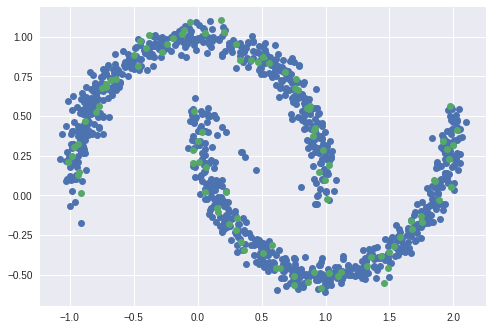

In [ ]:
data = realnvp.sample(1000)
data = data.detach().cpu().numpy()
print(data.shape)
plt.plot(data[:,0],data[:,1],'o')
noise_moons, _ = datasets.make_moons(n_samples = 100,noise = 0.05)
plt.plot(noise_moons[:,0],noise_moons[:,1],'o')

Text(0.5, 1.0, 'Estimated P(x)')

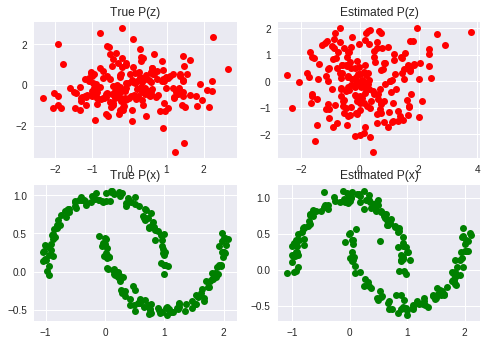

In [ ]:
sample_size = 200
sample_z = prior.sample((sample_size,))
noise_moons,_ = datasets.make_moons(n_samples = sample_size,shuffle = True,noise = .05)
noise_moons = torch.tensor(noise_moons.astype('float32')).to(device)
z, log_p = realnvp.log_prob(noise_moons)
estimated_noise_moons = realnvp.sample(sample_size)

z = z.detach().cpu().numpy()
sample_z = sample_z.numpy()
noise_moons = noise_moons.detach().cpu().numpy()
estimated_noise_moons = estimated_noise_moons.detach().cpu().numpy()


plt.subplots(2,2)
plt.subplot(2,2,1)
plt.plot(sample_z[:,0],sample_z[:,1],'o',color = 'r')
plt.title('True P(z)')
plt.subplot(2,2,2)
plt.plot(z[:,0],z[:,1],'o',color = 'r')
plt.title("Estimated P(z)")
plt.subplot(2,2,3)
plt.plot(noise_moons[:,0],noise_moons[:,1],'o',color = 'g')
plt.title('True P(x)')
plt.subplot(2,2,4)
plt.plot(estimated_noise_moons[:,0],estimated_noise_moons[:,1],'o',color = 'g')
plt.title('Estimated P(x)')

**問題檢討**<br>
在這次實作中，遇到需要將同一個structure的model定義多個，而原本想說用nn.ModuleList([scale_net for i in range(len(mask))])就能夠創立多個獨立的model，但結果是不行的，另一方面很不足的是當想要用已經產生model(module)，也就是如 scale_net = nn.Sequential(..)時，那如果我用在初始化
realnvp = RealNVP(scale_net..)，和realnvp2 = RealNVP(scale_net,...)，那這兩個model訓練時的scale_net是同一個，那這裡就要用以下的方式。<br>


方法一<br>
將model變為lambda，那這樣在使用上它會如同呼叫function一般，所以每次呼叫都是產生一個model，但是在使用時，我們把它產生的model都放到另一個model(也就是RealNVP)中，就是nn.ModuleList(...)時，那這樣就能確保是產生不同個model的。<br>

方法二<br>
乖乖產生多個model而非用上述的方式，<br>
scale_net1 = nn.Sequential(..)<br>
scale_net2 = nn.Sequential(..)<br>
...<br>

那這裡再補充複製model的方式，<br>
import copy<br>
model2 = copy.deepcopy(model)<br>
如此model2就會有和model有相同的structure了(當下參數值也應該是一樣的)。


